In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score


In [2]:
# 读取数据
df = pd.read_excel('AD.xlsx')
df

DIPOCE  DI_NCO       PO_HV      PO_f  BA_Code  BA_Mn     PO_Phr  \
0    110100000    31.0  367.991736  4.464132   1000.0   18.0  67.567568   
1    110100000    31.0  367.991736  4.464132   1000.0   18.0  67.567568   
2    100010000    31.5  440.000000  3.976049   1000.0   18.0  50.676157   
3    100100100    31.5  429.326712  4.146095   1000.0   18.0  32.931727   
4    100100100    31.5  418.118624  3.972837   1000.0   18.0  30.906059   
..         ...     ...         ...       ...      ...    ...        ...   
288  100010000    31.0  416.000000  2.000000   1000.0   18.0  73.421439   
289  100010000    31.0  416.000000  2.000000   1000.0   18.0  80.515298   
290  100010000    31.0  416.000000  2.000000   1000.0   18.0  84.104289   
291  100010000    31.0  416.000000  2.000000   1000.0   18.0  85.251492   
292  100010000    31.0  416.000000  2.000000   1000.0   18.0  86.505190   

       BA_Phr    FS_Phr   Cata_Phr    f(H2O)    M_loss      Yield     R  \
0    2.182432  1.013514   1.013514  0.180000  5.351351  96.884711  1.83   
1    2.182432  1.013514   1.013514  0.180000  5.351351  96.884711  1.83   
2    1.494662  1.010676  64.000000  0.167000  5.229893  97.017857  1.10   
3    0.975330  0.659782  51.500000  0.167000  4.215720  97.377587  1.10   
4    0.990550  0.617009  50.100000  0.167000  4.084491  97.428971  1.10   
..        ...       ...        ...       ...       ...        ...   ...   
288  2.276065  1.101322   0.367107  0.172222  5.563713  96.859603  1.10   
289  1.328502  1.207729   0.402576  0.091667  3.247450  98.229830  1.10   
290  0.849453  1.261564   0.420521  0.056111  2.076441  98.887437  1.10   
291  0.699062  1.278772   0.426257  0.045556  1.708819  99.089386  1.10   
292  0.527682  1.297578   0.432526  0.033889  1.289889  99.316662  1.10   

           CHS     Q  Cata_Code      MCS  classification  
0    59.700000   0.0     100000  108.600               0  
1    59.700000   0.0     100000   94.100               0  
2    58.400000   0.0     100100  310.000               0  
3    63.500000   0.0     100100  220.000               0  
4    64.600000   0.0     100100  210.000               0  
..         ...   ...        ...      ...             ...  
288  57.662997  48.0     100000  239.010               0  
289  55.396967  48.0     100000  189.713               1  
290  54.317040  48.0     100000  181.313               1  
291  53.980672  48.0     100000  179.315               1  
292  53.617811  48.0     100000  176.237               1  

[293 rows x 19 columns]

In [3]:
y = df['classification']
X = df.drop(columns=['classification'])

In [4]:
import json
from catboost import CatBoostRegressor

# 读取超参数
with open('AD_best_params.json', 'r') as f:
    params = json.load(f)

In [5]:
import json
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier  # 你的代码里用的是分类任务，改成分类器
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

best_model = CatBoostClassifier(**params,  random_state=42, verbose=0)

# 评估函数
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# 初始化存储容器
train_accuracy_scores, val_accuracy_scores = [], []
train_precision_scores, val_precision_scores = [], []
train_recall_scores, val_recall_scores = [], []
train_f1_scores, val_f1_scores = [], []
results, tprs, aucs = [], [], []
mean_fpr = np.linspace(0, 1, 100)

# 收集所有验证集真实值和预测概率
all_y_val = []
all_y_pred_val = []

# 交叉验证设置
cv = KFold(n_splits=3, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(cv.split(X), start=1):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # 训练模型
    best_model.fit(X_train, y_train)

    # 预测类别
    y_pred_train = best_model.predict(X_train)
    y_pred_val = best_model.predict(X_val)

    # 收集验证集预测类别
    all_y_val.extend(y_val)
    all_y_pred_val.extend(y_pred_val)

    # 评估指标计算
    accuracy_train, precision_train, recall_train, f1_train = evaluate_model(y_train, y_pred_train)
    accuracy_val, precision_val, recall_val, f1_val = evaluate_model(y_val, y_pred_val)

    train_accuracy_scores.append(accuracy_train)
    val_accuracy_scores.append(accuracy_val)
    train_precision_scores.append(precision_train)
    val_precision_scores.append(precision_val)
    train_recall_scores.append(recall_train)
    val_recall_scores.append(recall_val)
    train_f1_scores.append(f1_train)
    val_f1_scores.append(f1_val)

    # 预测概率，用于绘制ROC
    y_prob = best_model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    results.append({'fold': fold, 'fpr': fpr, 'tpr': tpr, 'auc': roc_auc})

# 汇总结果到DataFrame
df_results = pd.DataFrame({
    'Fold': range(1, 4),
    'accuracy_train': train_accuracy_scores,
    'accuracy_val': val_accuracy_scores,
    'precision_train': train_precision_scores,
    'precision_val': val_precision_scores,
    'recall_train': train_recall_scores,
    'recall_val': val_recall_scores,
    'f1_train': train_f1_scores,
    'f1_val': val_f1_scores
})
df_results

Fold  accuracy_train  accuracy_val  precision_train  precision_val  \
0     1        0.994872      0.897959         0.994924       0.898539   
1     2        0.984615      0.938776         0.984661       0.938776   
2     3        0.989796      0.865979         0.989796       0.866394   

   recall_train  recall_val  f1_train    f1_val  
0      0.994872    0.897959  0.994872  0.897874  
1      0.984615    0.938776  0.984612  0.938776  
2      0.989796    0.865979  0.989796  0.866094

In [6]:
# import json
# import numpy as np
# import pandas as pd
# from catboost import CatBoostClassifier  # 你的代码里用的是分类任务，改成分类器
# from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
# from sklearn.model_selection import KFold

# best_model = CatBoostClassifier(**params,  random_state=42, verbose=0)

# # 评估函数
# def evaluate_model(y_true, y_pred):
#     accuracy = accuracy_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')
#     f1 = f1_score(y_true, y_pred, average='weighted')
#     return accuracy, precision, recall, f1

# # 初始化存储容器
# train_accuracy_scores, val_accuracy_scores = [], []
# train_precision_scores, val_precision_scores = [], []
# train_recall_scores, val_recall_scores = [], []
# train_f1_scores, val_f1_scores = [], []
# results, tprs, aucs = [], [], []
# mean_fpr = np.linspace(0, 1, 100)

# # 收集所有验证集真实值和预测概率
# all_y_val = []
# all_y_pred_val = []

# # 交叉验证设置
# cv = KFold(n_splits=3, shuffle=True, random_state=42)

# for fold, (train_index, val_index) in enumerate(cv.split(X), start=1):
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # 训练模型
#     best_model.fit(X_train, y_train, cat_features=None, verbose=0)

#     # 预测类别
#     y_pred_train = best_model.predict(X_train)
#     y_pred_val = best_model.predict(X_val)

#     # 收集验证集预测类别
#     all_y_val.extend(y_val)
#     all_y_pred_val.extend(y_pred_val)

#     # 评估指标计算
#     accuracy_train, precision_train, recall_train, f1_train = evaluate_model(y_train, y_pred_train)
#     accuracy_val, precision_val, recall_val, f1_val = evaluate_model(y_val, y_pred_val)

#     train_accuracy_scores.append(accuracy_train)
#     val_accuracy_scores.append(accuracy_val)
#     train_precision_scores.append(precision_train)
#     val_precision_scores.append(precision_val)
#     train_recall_scores.append(recall_train)
#     val_recall_scores.append(recall_val)
#     train_f1_scores.append(f1_train)
#     val_f1_scores.append(f1_val)

#     # 预测概率，用于绘制ROC
#     y_prob = best_model.predict_proba(X_val)[:, 1]
#     fpr, tpr, _ = roc_curve(y_val, y_prob)
#     roc_auc = auc(fpr, tpr)
#     aucs.append(roc_auc)

#     tpr_interp = np.interp(mean_fpr, fpr, tpr)
#     tpr_interp[0] = 0.0
#     tprs.append(tpr_interp)

#     results.append({'fold': fold, 'fpr': fpr, 'tpr': tpr, 'auc': roc_auc})

# # 汇总结果到DataFrame
# df_results = pd.DataFrame({
#     'Fold': range(1, 4),
#     'accuracy_train': train_accuracy_scores,
#     'accuracy_val': val_accuracy_scores,
#     'precision_train': train_precision_scores,
#     'precision_val': val_precision_scores,
#     'recall_train': train_recall_scores,
#     'recall_val': val_recall_scores,
#     'f1_train': train_f1_scores,
#     'f1_val': val_f1_scores
# })


In [7]:
df_results

Fold  accuracy_train  accuracy_val  precision_train  precision_val  \
0     1        0.994872      0.897959         0.994924       0.898539   
1     2        0.984615      0.938776         0.984661       0.938776   
2     3        0.989796      0.865979         0.989796       0.866394   

   recall_train  recall_val  f1_train    f1_val  
0      0.994872    0.897959  0.994872  0.897874  
1      0.984615    0.938776  0.984612  0.938776  
2      0.989796    0.865979  0.989796  0.866094

In [8]:
# 获取需要计算的列（去除'Fold'列）
cols = df_results.drop('Fold', axis=1).columns

# 计算每一列的平均值和标准差
mean = df_results[cols].mean()
std = df_results[cols].std()

# 生成中间加减的形式，并保留两位小数
result = mean.round(2).astype(str) + ' ± ' + std.round(2).astype(str)

# 打印结果
print(result)


accuracy_train     0.99 ± 0.01
accuracy_val        0.9 ± 0.04
precision_train    0.99 ± 0.01
precision_val       0.9 ± 0.04
recall_train       0.99 ± 0.01
recall_val          0.9 ± 0.04
f1_train           0.99 ± 0.01
f1_val              0.9 ± 0.04
dtype: object


In [9]:
import joblib

# 保存模型到本地（.joblib格式）
joblib.dump(best_model, "F:/codes/00-WORK/work-1/01-myself/01-predict/01-model/HD_LD.joblib")  

['F:/codes/00-WORK/work-1/01-myself/01-predict/01-model/HD_LD.joblib']

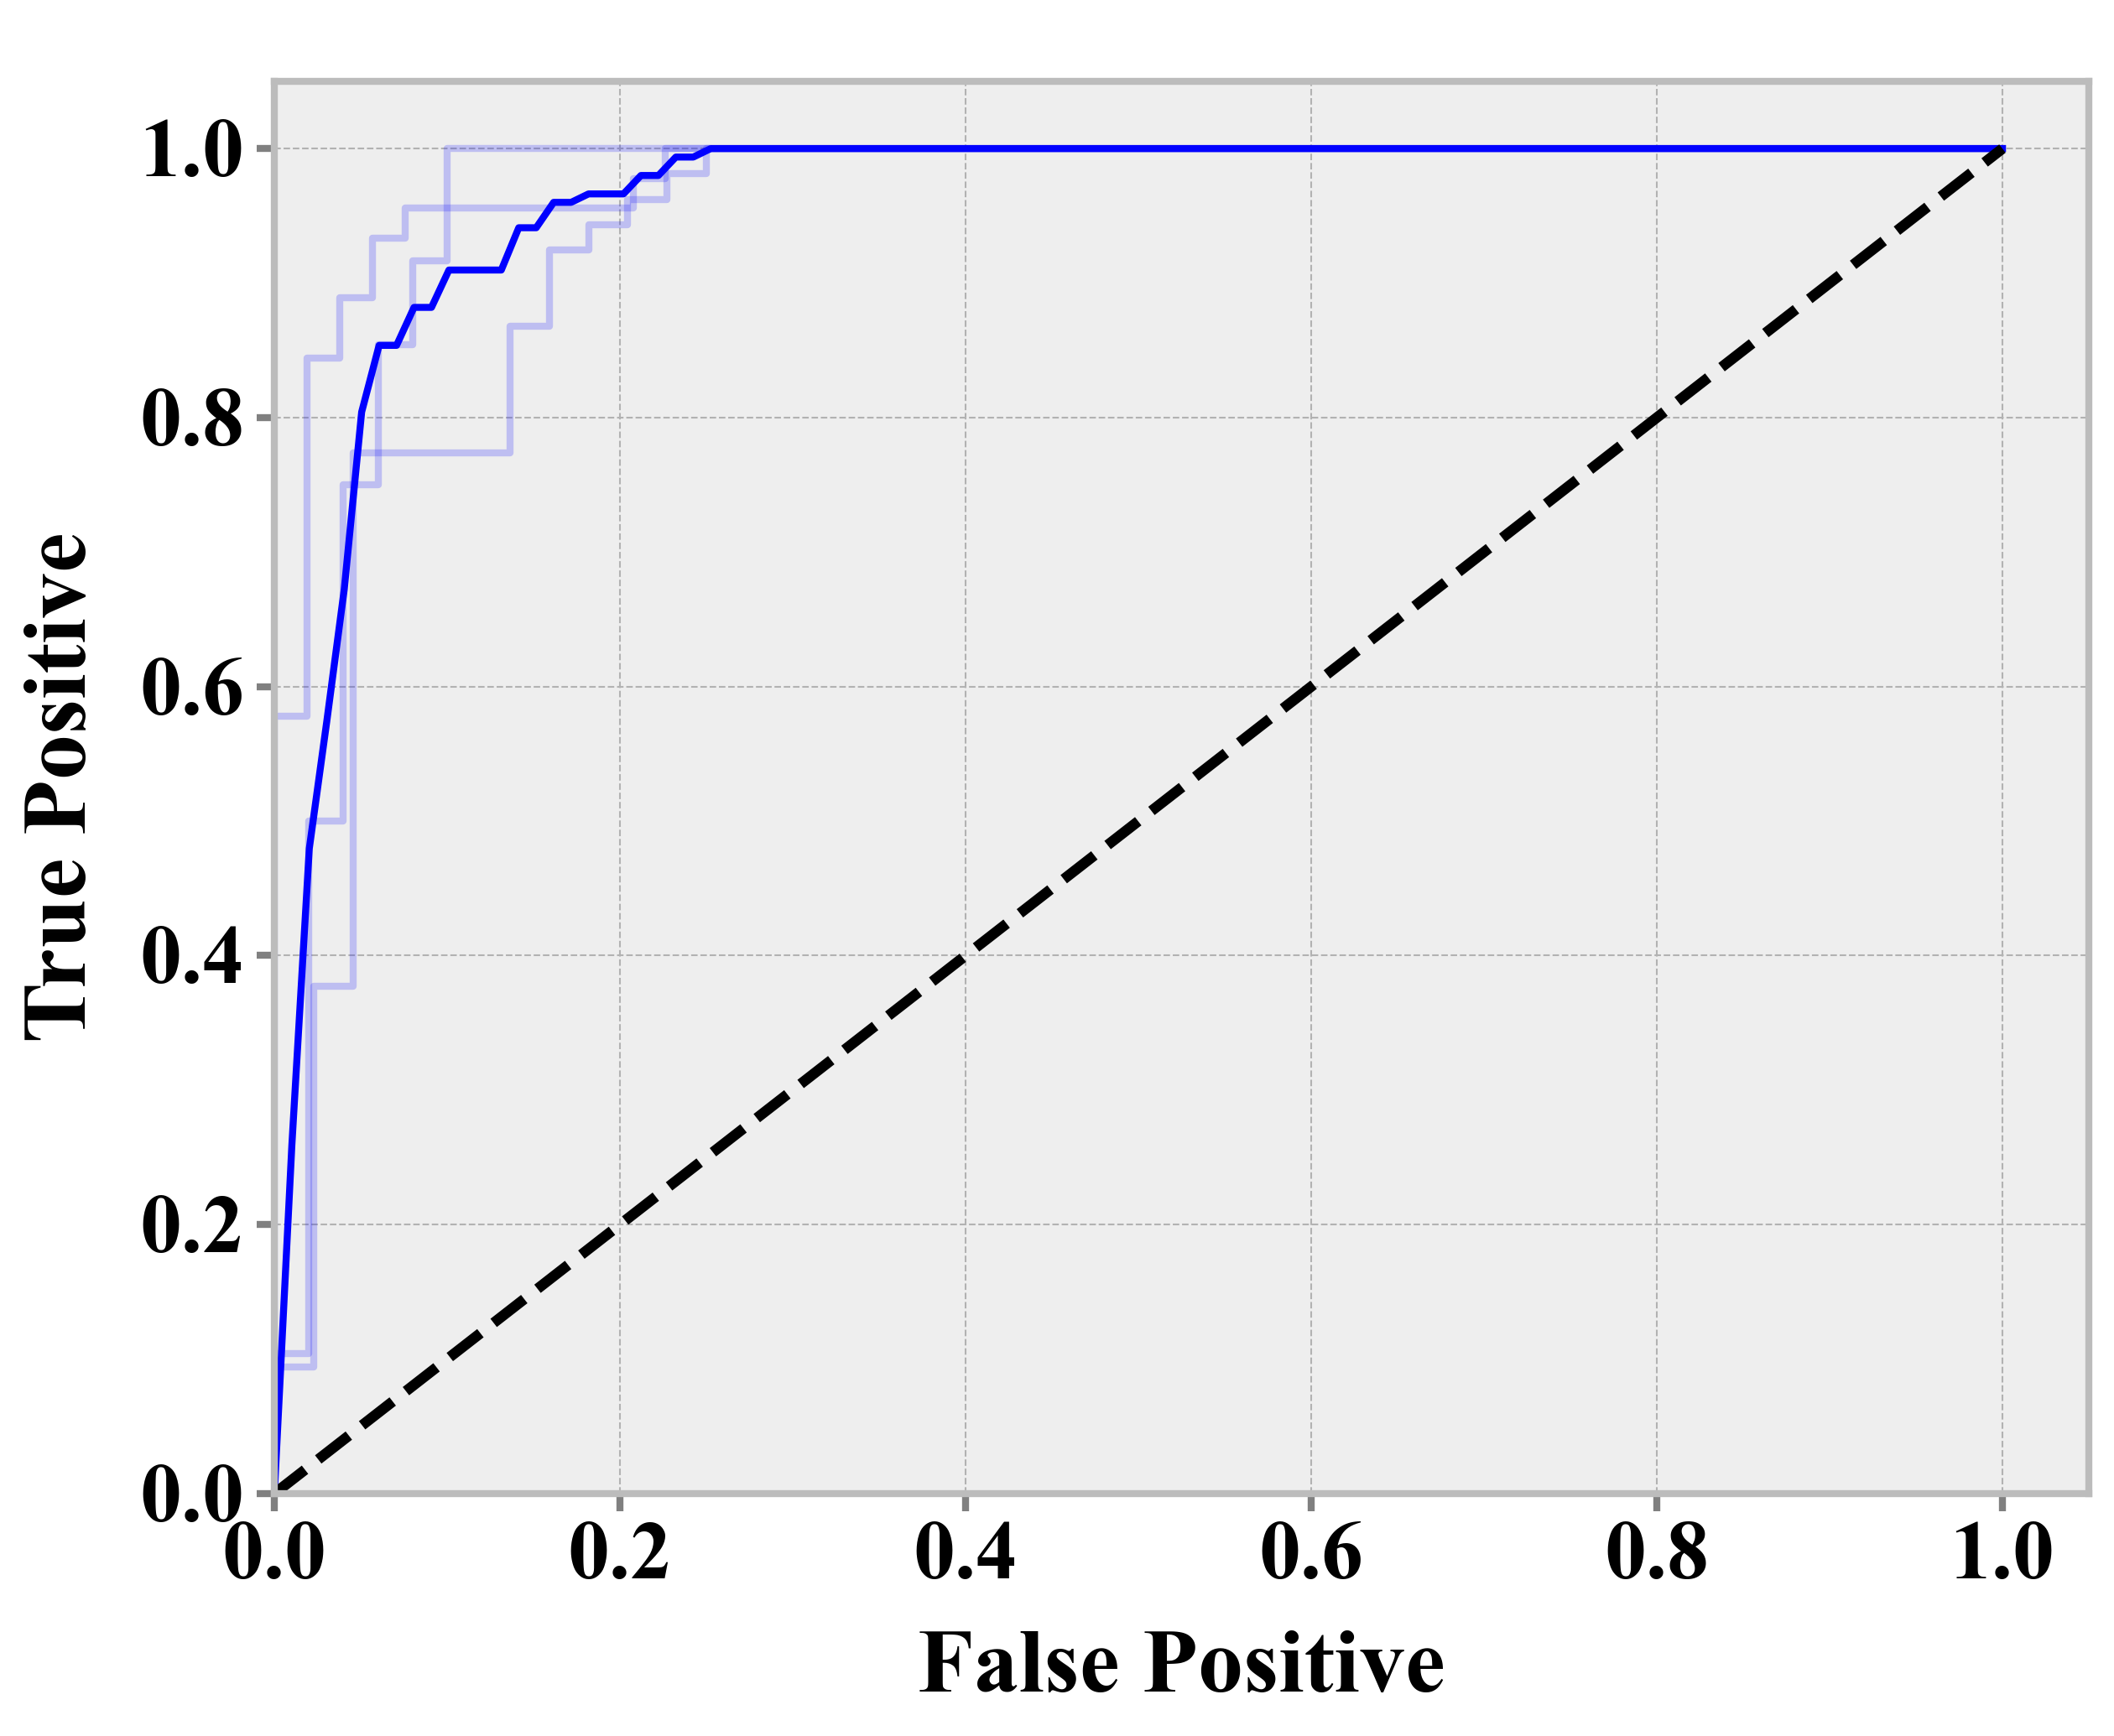

In [10]:
plt.figure(figsize=(8.5, 7), dpi=300)
plt.style.use('bmh')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.linewidth'] = 2
 
# # 画每一折的ROC
# for r in results:
#     plt.plot(r['fpr'], r['tpr'], lw=2, alpha=0.5, label=f"Fold {r['fold']}  = {r['auc']:.2f}")
 
# 画每一折的ROC
for r in results:
    plt.plot(r['fpr'], r['tpr'], lw=2, alpha=0.2, color="blue")

# 平均ROC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='blue',
         label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
         lw=2, alpha=1)

plt.plot([0, 1], [0, 1], 'k--', lw=3)

# 图表修饰
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.xlabel('False Positive', fontsize=26, fontweight='bold', labelpad=10, color='black')
plt.ylabel('True Positive', fontsize=26, fontweight='bold', labelpad=10, color='black')
plt.xticks(fontsize=24, fontweight='bold', color='black')
plt.yticks(fontsize=24, fontweight='bold', color='black')
plt.tick_params(axis='both', which='both', direction='out', length=5, width=2, color='gray', bottom=True, top=False, left=True, right=False)

plt.title(' ')
# plt.legend(loc='lower right',  frameon=False, handlelength=2, handleheight=1, prop={'size': 20, 'weight': 'bold', 'family': 'Times New Roman'})

plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
import numpy as np

def save_roc_to_excel(results, tprs, mean_fpr, aucs, filename='ROC_AD.xlsx'):
    """
    保存每一折和平均 ROC 曲线数据到 Excel 文件。

    参数:
    - results: 每一折包含 fpr, tpr, auc 的字典列表
    - tprs: 所有折插值后的 tpr 列表
    - mean_fpr: 通用的 fpr 横坐标（np.linspace）
    - aucs: 每一折的 AUC 值
    - filename: 输出 Excel 文件名
    """

    # 计算平均 TPR 和 AUC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)

    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        # 每折 ROC 数据
        fold_data = []
        for res in results:
            fold = res['fold']
            for fpr_val, tpr_val in zip(res['fpr'], res['tpr']):
                fold_data.append({'Fold': fold, 'FPR': fpr_val, 'TPR': tpr_val})
        df_folds = pd.DataFrame(fold_data)
        df_folds.to_excel(writer, sheet_name='ROC_Folds', index=False)

        # 平均 ROC 曲线
        df_mean = pd.DataFrame({
            'FPR': mean_fpr,
            'TPR': mean_tpr
        })
        df_mean['Mean AUC'] = mean_auc
        df_mean.to_excel(writer, sheet_name='ROC_Mean', index=False)

    print(f"✅ ROC 曲线数据已保存为 {filename}")
save_roc_to_excel(results, tprs, mean_fpr, aucs, filename='ROC_AD.xlsx')

✅ ROC 曲线数据已保存为 ROC_AD.xlsx


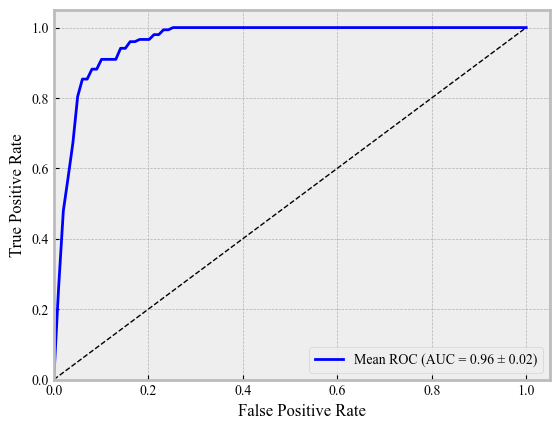

In [12]:
# 计算平均 ROC 曲线
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
# 绘制平均 ROC 曲线
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
         lw=2, alpha=1)

# 对角线
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# 美化图表
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Mean ROC Curve (5-Fold CV)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [13]:
# 计算整体混淆矩阵
cm = confusion_matrix(all_y_val, all_y_pred_val)

# 获取分类标签
class_labels = np.unique(all_y_val)

# 创建图形
plt.figure(figsize=(6, 5), dpi=300)

# 使用 seaborn 绘制热力图
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=class_labels, yticklabels=class_labels,
                 cbar=False, annot_kws={"size": 22, "weight": "bold", "fontname": "Times New Roman"})

# 设置标签字体
plt.xlabel("Predicted Label", fontsize=22, fontweight='bold', fontname='Times New Roman', labelpad=10)
plt.ylabel("True Label", fontsize=22, fontweight='bold', fontname='Times New Roman', labelpad=10)

# 设置坐标轴刻度字体
plt.xticks(fontsize=22, fontweight='bold', fontname='Times New Roman')
plt.yticks(fontsize=22, fontweight='bold', fontname='Times New Roman')
# 设置坐标轴刻刻度向外
ax.tick_params(axis='x', direction='out', length=5, width=1.5, colors='black')
ax.tick_params(axis='y', direction='out', length=5, width=1.5, colors='black')
# 设置边框线可见
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_color('black')

#去掉网格
plt.grid(False)

# 布局优化 + 显示
plt.tight_layout()
plt.show()


NameError: name 'confusion_matrix' is not defined

In [ ]:
import shap
# 创建一个SHAP解释器
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X, check_additivity=False)
shap_values

array([[-0.25780672,  0.28094055, -0.48262739, ..., -0.03120686,
         0.03577978,  0.28904905],
       [-0.25517342,  0.28184971, -0.46753597, ..., -0.03120686,
         0.04309941,  0.32470184],
       [ 0.3352652 ,  0.42468725, -0.16089699, ..., -0.0123342 ,
         0.09478412,  0.40126144],
       ...,
       [ 0.2249344 ,  0.33147665,  0.44314345, ...,  0.01948801,
         0.0930414 ,  0.3555874 ],
       [ 0.21222064,  0.30370148,  0.4605231 , ...,  0.01916806,
         0.09288457,  0.16961823],
       [ 0.21222064,  0.30766105,  0.46519383, ...,  0.01731189,
         0.09002573,  0.17098674]])

In [ ]:
shap_values.shape

(196, 22)

In [ ]:
import shap
import os
import matplotlib.pyplot as plt

# 设置字体和样式
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 20
plt.style.use('bmh')

# 创建主图
fig, ax1 = plt.subplots(figsize=(10, 8), dpi=1200)

shap.summary_plot(shap_values, X, feature_names=X.columns,
    plot_type="dot", show=False, color_bar=False, max_display=24)

plt.gca().set_position([0.2, 0.2, 0.65, 0.65])  # 调整位置为主图 ax1
ax1 = plt.gca()

# 顶部条形图（bar plot）
ax2 = ax1.twiny()
shap.summary_plot(
    shap_values, X, feature_names=X.columns,
    plot_type="bar", show=False, max_display=24
)
plt.gca().set_position([0.2, 0.2, 0.65, 0.65])  # 确保对齐

# 添加灰色参考线
ax2.axhline(y=24, color='gray', linestyle='-', linewidth=2)
# 设置透明度
for bar in ax2.patches:
    bar.set_alpha(0.2)
# 坐标轴标签设置,新罗马字体
ax1.set_xlabel('Shapley Value Contribution', fontsize=20, labelpad=10, weight='bold', fontname='Times New Roman')
ax1.set_ylabel('Features', fontsize=20, labelpad=10, weight='bold', fontname='Times New Roman')

ax2.set_xlabel('Mean (|Shapley Value|)', fontsize=20, labelpad=10, weight='bold', fontname='Times New Roman')
ax2.xaxis.set_label_position('top')
ax2.xaxis.tick_top()

# 设置三个坐标轴的刻度字体大小和粗细
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontsize(18)
    label.set_fontweight('bold')
    label.set_fontname('Times New Roman')

for label in ax2.get_xticklabels():
    label.set_fontsize(18)
    label.set_fontweight('bold')
    label.set_fontname('Times New Roman')

# 调整排版，保存并展示
plt.tight_layout()
plt.show()